In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time 
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB', 'STHeiti', 'PingFang SC', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

np.random.seed(42)

第一步：生成模拟数据
我们创建一些简单的二维数据，方便可视化理解

In [ ]:
def generate_sample_data(n_samples=1000, dim=2):
    '''
    生成3个明显分离的高斯分布簇
    loc是均值mean
    scale是标准差
    '''
    cluster1 = np.random.normal(loc=[2,2], scale=0.5, size=(n_samples//3, dim))
    cluster2 = np.random.normal(loc=[8,3], scale=0.6, size=(n_samples//3, dim))
    cluster3 = np.random.normal(loc=[5,8], scale=0.4, size=(n_samples - 2*(n_samples//3), dim))

    # vertical stack 将多个数组沿第一个轴
    data = np.vstack([cluster1, cluster2, cluster3])
    return data

In [4]:
data = generate_sample_data() 
print(f'数据形状: {data.shape}')

数据形状: (1000, 2)


第二步：实现K-means聚类

这是IVF算法的核心预处理步骤

In [8]:
class SimpleKMeans:
    '''
    简单的K-Means算法实现
    '''
    def __init__(self, n_cluster=3, max_iters=100) -> None:
        self.n_cluster = n_cluster
        self.max_iters = max_iters
        self.centroids = None
        self.labels_ = None

    def fit(self, X):
        # num, dim
        n_samples, n_features = X.shape

        # 1.随机初始化质心
        random_indices = np.random.choice(n_samples, self.n_cluster, replace=False)
        self.centroids = X[random_indices]

        for it in range(self.max_iters):
            # 2. 分配每个点到最近的质心
            distances = euclidean_distances(X, self.centroids) # shape(n_sample, n_centroids)
            # 对每个数据点，找到距离最近的质心索引
            labels = np.argmin(distances, axis=1)   # shape(n_sample, 1)

            # 3. 更新质心位置
            # 对每个聚类 i（从 0 到 n_cluster-1）
            #   X[labels == i]：筛选出所有被分配到聚类 i 的数据点
            #   mean(axis=0)：计算这些点在每个特征维度上的均值，得到该聚类的新质心
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_cluster)])
            # 如果所有对应质心都足够接近，返回 True，表示已收敛
            if np.allclose(self.centroids, new_centroids):
                # 如果质心不再显著变化，提前结束迭代，避免不必要的计算
                break
            self.centroids = new_centroids

        self.labels_ = labels
        return self

第三步：实现倒排文件索引（IVF）

In [9]:
class SimpleIVF:
    '''
    简易IVF实现
    '''
    def __init__(self, n_clusters=3, n_probe=2) -> None:
        self.n_clusters = n_clusters
        self.n_probe = n_probe  # 搜索时探测的簇数量
        self.kmeans = None
        self.inverted_lists = None # 倒排列表
        self.centroids = None
        self.is_trained = False

    def train(self, data):
        ''' 对数据进行聚类 '''
        print('start training IVF index...')
        self.kmeans = SimpleKMeans(n_cluster=self.n_clusters)
        self.kmeans.fit(data)
        self.centroids = self.kmeans.centroids
        self.is_trained = True
        print(f'training completed, {self.centroids} clusters')

    def build_index(self, data):
        '''构建倒排索引'''
        if not self.is_trained:
            self.train(data)

        # 初始化倒排列表
        self.inverted_lists = defaultdict(list)

        # 将每个向量分配给最近的簇
        distances = euclidean_distances(data, self.centroids)
        labels = np.argmin(distances, axis=1) # vector_id -> cluster_id

        # 构建倒排列表：cluster_id -> 该Cluster的所有向量id
        for idx, label in enumerate(labels):
            self.inverted_lists[label].append(idx)

        print('inverted index build success.')
        for cluster_id, items in self.inverted_lists.items():
            print(f' cluster {cluster_id}: {len(items)} vectors')

    def search(self, query, k=5, data=None):
        '''IVF搜索，先找最近的cluster,然后在cluster内搜索'''
        if data is None:
            data = self.data

        # 1.粗略搜索：找到最近的n_probs个Cluster
        distances_to_centroids = euclidean_distances([query], self.centroids)[0]
        nearest_cluster_indices = np.argsort(distances_to_centroids)[:self.n_probe]

        # 2.精细搜索：在选中的cluster内进行暴力搜索
        candidate_indices = []  # 候选的索引在data中的index
        for cluster_id in nearest_cluster_indices:
            candidate_indices.extend(self.inverted_lists[cluster_id])

        if not candidate_indices:
            return [], []

        # 3. 在候选向量中计算距离
        candidate_vectors = data[candidate_indices]
        distances = euclidean_distances([query], candidate_vectors)[0]

        if k > len(distances):
            k = len(distances)
        
        # 获取最邻近的k个结果 
        # 在candidate_vectors中，与query距离最近的k个向量的索引
        nearest_indices_within_candidates = np.argsort(distances)[:k]

        # 映射回原始索引
        final_indices = [candidate_indices[i] for i in nearest_indices_within_candidates]
        final_distancs = distances[nearest_indices_within_candidates]

        return final_indices, final_distancs

    def brute_force_search(self, query, k=5, data=None):
        ''' 暴力搜索作为对比基准 '''
        if data is None:
            data = self.data

        distances = euclidean_distances([query], data)[0]
        nearest_indices = np.argsort(distances)[:k]
        return nearest_indices, distances[nearest_indices]

In [18]:
def run_ivf(data_size=1000):
    ''' 完整演示IVF算法 '''
    print('=' * 60)
    print('IVF算法演示')
    print('=' * 60)

    # 1. 生成数据
    data = generate_sample_data(data_size, 2)
    print(f'生成{len(data)}个二维数据点')

    # 2. 创建并训练IVF索引
    ivf = SimpleIVF(n_clusters=3, n_probe=2)
    ivf.data = data
    ivf.build_index(data)

    # 3. 查询数据
    query_point = np.array([5.0, 5.0])
    print(f'\n查询点: {query_point}')

    # 4. 使用IVF搜索
    start_time = time.time()
    ivf_indices, ivf_distances = ivf.search(query_point, k=5, data=data)
    ivf_time = time.time() - start_time

    # 5. 使用暴力搜索作为对比
    start_time = time.time()
    bf_indices, bf_distances = ivf.brute_force_search(query_point, k=5, data=data)
    bf_time = time.time() - start_time

    # 6. 显示结果
    print(f'\n搜索结果对比:')
    print(f'IVF搜索  - 找到{len(ivf_indices)}个最近邻, 耗时: {ivf_time:.6f}秒')
    print(f'暴力搜索 - 找到{len(bf_indices)}个最近邻, 耗时: {bf_time:.6f}秒')
    
    print(f'\n速度提升: {bf_time/ivf_time:.2f}倍')
    
    print(f'\n最近邻索引 (IVF): {ivf_indices}')
    print(f'最近邻索引 (暴力): {bf_indices}')

    # 7. 检查召回率
    intersection = set(ivf_indices) & set(bf_indices)
    recall = len(intersection) / len(bf_indices)
    print(f'召回率: {recall:.2%} ({len(intersection)}/{len(bf_indices)})')

    return ivf, data, query_point, ivf_indices, bf_indices


In [15]:
ivf, data, query, ivf_results, bf_results = run_ivf()


IVF算法演示
生成30000个二维数据点
start training IVF index...
training completed, [[2.00802989 2.0008392 ]
 [5.00401347 8.00430203]
 [7.99585819 3.00215863]] clusters
inverted index build success.
 cluster 0: 10000 vectors
 cluster 2: 10000 vectors
 cluster 1: 10000 vectors

查询点: [5. 5.]

搜索结果对比:
IVF搜索  - 找到5个最近邻, 耗时: 0.008992秒
暴力搜索 - 找到5个最近邻, 耗时: 0.003443秒

速度提升: 0.38倍

最近邻索引 (IVF): [15800, 11183, 26196, 14138, 24560]
最近邻索引 (暴力): [15800 11183 26196 14138 24560]
召回率: 100.00% (5/5)


In [19]:
def visualize_ivf(ivf, data, query, ivf_results, bf_results):
    '''IVF算法可视化'''
    plt.figure(figsize=(15, 10))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
    
    # 计算查询相关信息
    distances_to_centroids = euclidean_distances([query], ivf.centroids)[0]
    nearest_cluster_indices = np.argsort(distances_to_centroids)[:ivf.n_probe]
    
    # 1. 原始数据分布
    plt.subplot(2, 3, 1)
    plt.scatter(data[:, 0], data[:, 1], c='lightblue', alpha=0.6, s=20, label='数据点')
    plt.title('1. 原始数据分布', fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 2. K-means聚类
    plt.subplot(2, 3, 2)
    for cluster_id, indices in ivf.inverted_lists.items():
        cluster_data = data[indices]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                   c=colors[cluster_id % len(colors)], alpha=0.7, s=25,
                   label=f'簇{cluster_id}')
    
    plt.scatter(ivf.centroids[:, 0], ivf.centroids[:, 1], 
               c='black', marker='X', s=100, linewidths=2, label='质心')
    plt.title('2. K-means聚类', fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 3. 粗略搜索
    plt.subplot(2, 3, 3)
    
    # 背景：显示所有数据点（淡化）
    plt.scatter(data[:, 0], data[:, 1], c='lightgray', alpha=0.2, s=10)
    
    # 显示所有质心，用不同透明度区分选中和未选中
    selected_centroids = set(nearest_cluster_indices)
    
    for i, centroid in enumerate(ivf.centroids):
        if i in selected_centroids:
            # 选中的质心：高亮显示
            plt.scatter(centroid[0], centroid[1], c='red', marker='X', 
                       s=120, linewidths=2, edgecolors='darkred', alpha=0.9)
            # 显示到查询点的距离线
            plt.plot([query[0], centroid[0]], [query[1], centroid[1]], 
                    'r-', alpha=0.8, linewidth=2)
            # 标注距离值
            dist = np.linalg.norm(query - centroid)
            mid_x, mid_y = (query[0] + centroid[0])/2, (query[1] + centroid[1])/2
            plt.annotate(f'{dist:.1f}', (mid_x, mid_y), 
                        xytext=(0, 10), textcoords='offset points',
                        fontsize=8, ha='center', color='red', fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        else:
            # 未选中的质心：淡化显示
            plt.scatter(centroid[0], centroid[1], c='gray', marker='X', 
                       s=80, alpha=0.4, linewidths=1)
            # 显示到查询点的距离线（虚线）
            plt.plot([query[0], centroid[0]], [query[1], centroid[1]], 
                    'gray', linestyle=':', alpha=0.3, linewidth=1)
    
    # 查询点
    plt.scatter(query[0], query[1], c='#FFD93D', marker='*', s=200, 
               edgecolors='black', linewidth=2, label='查询点', zorder=10)
    
    # 添加选择说明
    plt.title(f'3. 粗略搜索：选择最近的{ivf.n_probe}个质心', fontweight='bold')
    
    # 创建图例
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='*', color='w', markerfacecolor='#FFD93D', 
               markersize=12, markeredgecolor='black', label='查询点'),
        Line2D([0], [0], marker='X', color='w', markerfacecolor='red', 
               markersize=10, markeredgecolor='darkred', label='选中质心'),
        Line2D([0], [0], marker='X', color='w', markerfacecolor='gray', 
               markersize=8, alpha=0.6, label='未选中质心'),
        Line2D([0], [0], color='red', linewidth=2, label='选中距离'),
        Line2D([0], [0], color='gray', linestyle=':', alpha=0.5, label='未选中距离')
    ]
    plt.legend(handles=legend_elements, fontsize=7, loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # 4. 精细搜索
    plt.subplot(2, 3, 4)
    
    # 背景：显示所有数据点（淡化）
    plt.scatter(data[:, 0], data[:, 1], c='lightgray', alpha=0.2, s=10)
    
    # 显示选中的质心
    for cluster_idx in nearest_cluster_indices:
        plt.scatter(ivf.centroids[cluster_idx, 0], ivf.centroids[cluster_idx, 1], 
                   c='red', marker='X', s=100, linewidths=2, edgecolors='darkred', alpha=0.8)
    
    # 收集并按簇显示候选向量
    candidate_indices = []
    cluster_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    for i, cluster_idx in enumerate(nearest_cluster_indices):
        cluster_candidates = ivf.inverted_lists[cluster_idx]
        candidate_indices.extend(cluster_candidates)
        
        # 用不同颜色显示不同簇的候选向量
        cluster_data = data[cluster_candidates]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], 
                   c=cluster_colors[i % len(cluster_colors)], alpha=0.7, s=30,
                   label=f'簇{cluster_idx}候选({len(cluster_candidates)}个)', 
                   edgecolors='black', linewidths=0.5)
    
    # 查询点
    plt.scatter(query[0], query[1], c='#FFD93D', marker='*', s=200, 
               edgecolors='black', linewidth=2, label='查询点', zorder=10)
    
    plt.title(f'4. 精细搜索：收集{len(candidate_indices)}个候选向量', fontweight='bold')
    plt.legend(fontsize=7, loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # 5. IVF结果
    plt.subplot(2, 3, 5)
    plt.scatter(data[:, 0], data[:, 1], c='lightgray', alpha=0.4, s=20)
    plt.scatter(data[ivf_results, 0], data[ivf_results, 1], 
               c='red', marker='o', s=60, edgecolors='darkred', 
               linewidth=2, label='IVF结果')
    
    for i, idx in enumerate(ivf_results[:5]):
        plt.annotate(f'{i+1}', (data[idx, 0], data[idx, 1]), 
                    xytext=(3, 3), textcoords='offset points', 
                    fontsize=8, color='white', fontweight='bold')
    
    plt.scatter(query[0], query[1], c='#FFD93D', marker='*', s=150, 
               edgecolors='black', linewidth=2, label='查询点')
    plt.title('5. IVF结果', fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 6. 结果对比
    plt.subplot(2, 3, 6)
    plt.scatter(data[:, 0], data[:, 1], c='lightgray', alpha=0.3, s=15)
    plt.scatter(data[bf_results, 0], data[bf_results, 1], 
               c='green', marker='s', s=60, edgecolors='darkgreen', 
               linewidth=2, label='暴力搜索', alpha=0.7)
    plt.scatter(data[ivf_results, 0], data[ivf_results, 1], 
               c='red', marker='o', s=50, alpha=0.8, label='IVF结果')
    plt.scatter(query[0], query[1], c='#FFD93D', marker='*', s=150, 
               edgecolors='black', linewidth=2, label='查询点')
    
    # 计算召回率
    intersection = set(ivf_results) & set(bf_results)
    recall = len(intersection) / len(bf_results)
    
    plt.title(f'6. 结果对比 (召回率: {recall:.1%})', fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 简化的统计信息
    total_candidates = sum(len(ivf.inverted_lists[i]) for i in nearest_cluster_indices)
    search_ratio = total_candidates / len(data)
    
    print(f'IVF算法统计:')
    print(f'数据量: {len(data)} 个向量')
    print(f'聚类数: {ivf.n_clusters} 个簇')
    print(f'搜索簇: {ivf.n_probe} 个簇')
    print(f'候选向量: {total_candidates} 个 ({search_ratio:.1%})')
    print(f'召回率: {recall:.1%}')
    
    return recall

IVF算法演示
生成100个二维数据点
start training IVF index...
training completed, [[5.02655817 7.90466404]
 [7.96711949 3.01598982]
 [1.92685287 2.09916703]] clusters
inverted index build success.
 cluster 2: 33 vectors
 cluster 1: 33 vectors
 cluster 0: 34 vectors

查询点: [5. 5.]

搜索结果对比:
IVF搜索  - 找到5个最近邻, 耗时: 0.002774秒
暴力搜索 - 找到5个最近邻, 耗时: 0.000863秒

速度提升: 0.31倍

最近邻索引 (IVF): [85, 69, 98, 78, 87]
最近邻索引 (暴力): [85 69 98 78 87]
召回率: 100.00% (5/5)


/tmp/ipython-input-4207699672.py:156: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4207699672.py:156: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4207699672.py:156: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4207699672.py:156: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4207699672.py:156: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4207699672.py:156: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4207699672.py:156: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}

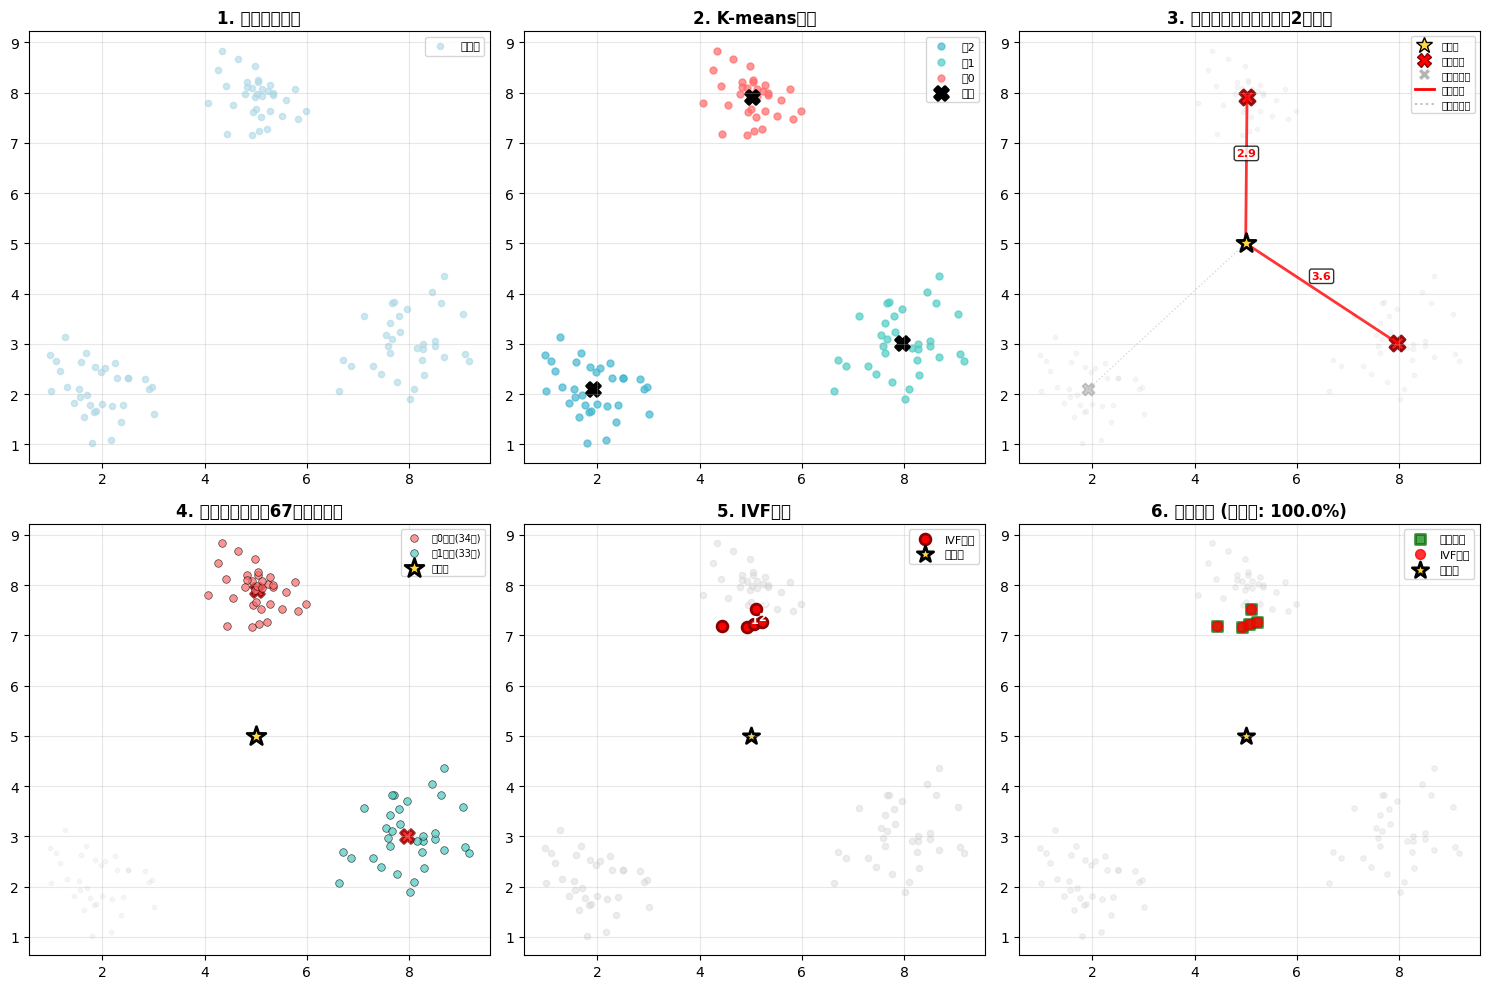

IVF算法统计:
数据量: 100 个向量
聚类数: 3 个簇
搜索簇: 2 个簇
候选向量: 67 个 (67.0%)
召回率: 100.0%


In [20]:
#用少量样本进行可视化
ivf_tiny, data_tiny, query_tiny, ivf_results_tiny, bf_results_tiny = run_ivf(data_size=100)
recall = visualize_ivf(ivf_tiny, data_tiny, query_tiny, ivf_results_tiny, bf_results_tiny)